In [ ]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split


import numpy as np
import scipy.stats as stats
import seaborn as sns
# for dataset management
import pandas as pd
import time
# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Reg-Data.txt to Reg-Data.txt


In [ ]:
data = pd.read_csv('Reg-Data.txt', sep=',')

In [ ]:
data.columns=np.arange(0,70,1)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,0.029105,0.407297,-0.034418,-0.000607,-1.587712,-0.134767,0.679050,0.867759,0.549205,-0.357172,-0.578459,0.293603,-0.369997,-0.360397,-0.088276,-0.684480,-0.420736,0.263000,0.074617,0.277973,0.468588,0.978996,0.586847,0.760345,1.400111,0.943587,-0.402494,0.058298,-0.221967,-0.302481,-0.539966,0.179847,-0.634147,-0.252916,-0.441251,-0.342925,0.628843,0.212837,-0.038171,-0.440290,-0.157062,1.627259,1.989545,-0.357803,-0.176835,0.406589,-0.623764,-0.653021,-0.082645,-0.947933,-0.495712,-0.465077,-0.157861,-0.157189,0.380951,1.088478,-0.123595,1.391141,14.91,-23.51
1,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,-0.903893,-0.791393,-1.667463,-0.334004,-0.151747,1.210807,1.045059,-0.672476,-0.463102,-0.747421,0.069946,0.305318,0.551537,-0.705611,-0.301218,-0.365297,0.062184,0.366565,0.870098,1.483239,0.614040,1.568182,1.743709,1.388536,-0.694375,-0.285767,-0.291778,-0.274901,-0.351297,0.439170,-0.663293,0.056928,0.801809,0.326462,0.579646,0.991642,1.612214,0.472009,1.060355,1.070834,0.408001,-0.654047,0.264883,-0.421474,-0.405171,0.170239,0.067260,-1.198657,-0.797954,-0.556109,-0.637167,0.147260,0.217914,2.718442,0.972919,2.081069,1.375763,1.063847,12.65,-8.00
2,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,0.024625,0.429205,0.576029,0.400389,0.519513,0.509497,1.303073,-0.055956,0.001966,2.255016,0.332082,-0.051894,0.376492,1.169377,-0.733187,0.672438,0.979776,0.390647,-0.519658,-0.675643,0.292994,0.349806,-0.058874,-0.521205,1.658281,1.254224,2.535289,0.537780,0.190260,-0.156088,0.707729,-1.073155,-0.428863,-0.663483,-0.304159,-0.203572,-0.200971,1.212091,1.193691,0.609952,-0.296156,2.301748,2.547275,1.485531,-0.179182,0.112038,0.983122,0.788367,-0.805626,0.166616,-0.178325,-0.065059,-0.724247,-1.020687,-0.751380,-0.385005,-0.012326,-0.392197,9.03,38.74
3,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,-0.287746,1.824638,-0.861848,-0.229361,-0.966604,0.278767,0.060231,0.035642,-0.044704,-0.718237,-0.733049,-1.136788,-1.301985,-0.312192,-0.671557,-0.579330,-0.772117,-0.371718,-0.483820,0.068485,0.682731,0.867177,0.769446,1.226698,0.557925,0.175588,-0.324638,-0.089385,-0.186612,-0.415299,1.094179,0.298009,-0.479234,0.239411,-0.388596,-0.013394,0.517086,0.120622,0.317070,0.287059,0.607333,0.984157,0.279686,-0.784654,-0.078594,-0.250279,-1.169305,-0.052781,-0.180181,-0.500785,-0.919463,-0.667912,-0.820172,-0.190488,0.306974,0.119658,0.271838,1.289783,34.03,-6.85
4,0.059217,0.034537,-0.703441,0.188652,-0.270353,1.420526,0.467766,0.209594,-0.496505,1.239908,0.241493,-0.258381,1.944521,-1.037235,0.250967,-0.106169,0.012665,1.208937,1.136594,-0.499356,-0.812315,0.707096,0.155801,0.451774,0.854111,1.211973,0.227121,-0.626188,-0.094155,-0.057997,-0.074075,-0.289063,-0.685688,-0.422618,1.791713,1.392260,-0.166716,0.290893,0.284940,1.040583,0.056155,1.119458,1.659770,-0.302015,0.164696,1.381299,-0.241382,0.089011,-0.454603,-0.398362,0.224597,2.949133,2.856510,0.039530,-0.196953,0.526687,1.241737,0.728226,1.404666,1.428818,0.501017,-0.354263,0.445184,0.060328,0.075293,-0.170387,-0.506187,-0.008470,12.65,-8.00


In [ ]:
# z-score all columns 
cols2zscore = data.keys()
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data[cols2zscore] = data[cols2zscore]/np.max(data[cols2zscore])#.apply(stats.zscore)
cols2zscore
# convert from pandas dataframe to tensor

# but first drop residual sugar
cols2zscore = cols2zscore.drop([68,69])

dataT = torch.tensor( data[cols2zscore].values ).float()
xy = torch.tensor( data[[68,69]].values ).float()
#sugar = sugar[:,None] # transform to matrix

In [ ]:
# use scikitlearn to split the data
train_dataSK,test_dataSK, train_labelsSK,test_labelsSK = train_test_split(dataT, xy, test_size=.15)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_dataSK,train_labelsSK)
test_dataDataset  = torch.utils.data.TensorDataset(test_dataSK,test_labelsSK)

# finally, translate into dataloader objects
# batchsize    = 32
# train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [ ]:
# create a class for the model
class ANNgc(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(68,1)
    ### output layer
    self.output = nn.Linear(1,2)
  
  # forward pass
  def forward(self,x):
    x = F.relu(self.input(x))
    return self.output(x) 

In [ ]:
# a function that trains the model

# global parameter
numepochs = 10

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.L1Loss()
  optimizer = torch.optim.Adam(gcnet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    gcnet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = gcnet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    gcnet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = gcnet(X)
    testLoss[epochi] = lossfun(yHat,y).item()
  
  # function output
  return trainLoss,testLoss

In [ ]:

# range of batch sizes
batchsizes = [32,64,256]

# initialize output results matrices
LossResultsTrain = np.zeros((numepochs,len(batchsizes)))
LossResultsTest  = np.zeros((numepochs,len(batchsizes)))

comptime             = np.zeros(len(batchsizes))


test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

  # start the clock
  starttime = time.process_time()

  # create dataloader object
  train_loader = DataLoader(train_dataDataset,
                          batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

  # create and train a model
  gcnet= ANNgc()
  trainLoss,testLoss = trainTheModel()

  # store data
  LossResultsTrain[:,bi] = trainLoss
  LossResultsTest[:,bi]  = testLoss

  # check the timer
  comptime[bi] = time.process_time() - starttime


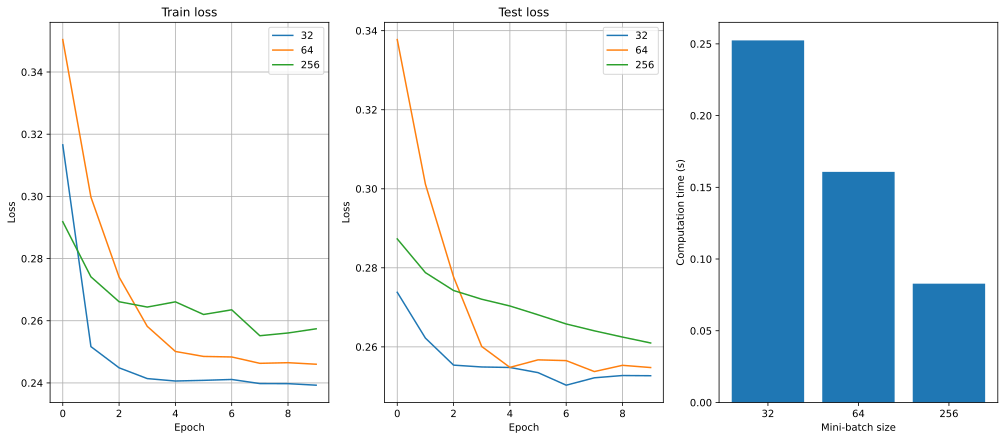

In [ ]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(17,7))

ax[0].plot(LossResultsTrain)
ax[1].plot(LossResultsTest)
ax[0].set_title('Train loss')
ax[1].set_title('Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[0].legend(batchsizes)
ax[0].grid()
ax[1].legend(batchsizes)
ax[1].grid()

# ax[2].legend(batchsizes)
# ax[2].set_xlabel('Epoch')
# ax[2].set_ylabel('Losses')
# ax[2].grid()

# plt.show()



# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()